In [2]:
"""
Importing needed libraries
"""
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
""" 
 Dataset path
"""
training_image_path = 'plant disease dataset/Train/Train'
validation_image_path = 'plant disease dataset/Validation/Validation'
testing_image_path = 'plant disease dataset/Test/Test'

In [4]:
""" 
Let's define the transformatiions that needed to be applied on the images. 
"""
image_transformation = transforms.Compose([
    transforms.Resize((128, 128)),  # resizing the image to 32x32
    transforms.ToTensor()  # Converting as tensor
])

In [5]:
""" 
Definig the dataset by applying transfromations on the datsset images.
"""
training_dataset = datasets.ImageFolder(
    training_image_path, transform=image_transformation)
validation_dataset = datasets.ImageFolder(
    validation_image_path, transform=image_transformation)
testing_dataset = datasets.ImageFolder(
    testing_image_path, transform=image_transformation)

In [6]:
"""  
Insights of defined dataset. 
"""

print("Size of Training Data : ", len(training_dataset))
print("Size of Validation Data : ", len(validation_dataset))
print("Size of Testing Data : ", len(testing_dataset))
print("Unique Classes : ", training_dataset.classes)

Size of Training Data :  1322
Size of Validation Data :  60
Size of Testing Data :  150
Unique Classes :  ['Healthy', 'Powdery', 'Rust']


## Base CNN model for plant disease prediction

In [7]:
""" 
Defining the dataloaders. 
    - batch_size : 32
"""
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
testing_loader = DataLoader(testing_dataset, batch_size=32)

In [8]:
""" 
Defining the basic CNN model to find how well it can predict plant disease. 
"""


class Base_CNN(nn.Module):
    def __init__(self):
        super(Base_CNN, self).__init__()
        # Definig 1 covolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Increased filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pooling = nn.MaxPool2d(2, 2)

        # Two fully connected layers
        self.fully_connected_1 = nn.Linear(64 * 32 * 32, 128)
        self.fully_connected_2 = nn.Linear(128, 3)  # 3 classes

    def forward(self, x):
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))  # Second conv + pooling
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fully_connected_1(x))
        x = self.fully_connected_2(x)
        return x

In [9]:
""" 
Initializing the Basic CNN model with, 
    - Loss : CrossEntropyLoss
    - Optimizer : SGD
    - Learning Rate : 0.01
"""
base_model = Base_CNN()
criterion_base_CNN = nn.CrossEntropyLoss()
optimizer_base_CNN = torch.optim.SGD(base_model.parameters(), lr=0.01)

In [10]:
"""
Training the Base CNN model.
"""
# Flags to store values for visualization
training_losses = []
training_accuracies = []
validation_accuracies = []

print("Starting training...")
epochs_count = 5

for epoch in range(epochs_count):
    base_model.train()
    epoch_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, labels in training_loader:
        optimizer_base_CNN.zero_grad()
        batch_outputs = base_model(inputs)
        batch_loss = criterion_base_CNN(batch_outputs, labels)
        batch_loss.backward()
        optimizer_base_CNN.step()

        epoch_loss += batch_loss.item()
        _, predicted = batch_outputs.max(1)
        training_total += labels.size(0)
        training_correct += predicted.eq(labels).sum().item()

    training_accuracy = 100. * training_correct / training_total
    training_losses.append(epoch_loss/len(training_loader))
    training_accuracies.append(training_accuracy)

    """ 
    Validation 
    """
    base_model.eval()
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = base_model(inputs)
            _, predicted = outputs.max(1)
            validation_total += labels.size(0)
            validation_correct += predicted.eq(labels).sum().item()

    validation_accuray = 100. * validation_correct / validation_total
    validation_accuracies.append(validation_accuray)

    print(f'Completed Base_CNN Epoch : {epoch+1}/{epochs_count} :')
    print(f'Training Loss: {epoch_loss/len(training_loader):.3f}')
    print(f'Training Accuracy: {training_accuracy:.2f}%')
    print(f'Validation Accuracy: {validation_accuray:.2f}%\n')

Starting training...
Completed Base_CNN Epoch : 1/5 :
Training Loss: 1.074
Training Accuracy: 40.24%
Validation Accuracy: 41.67%

Completed Base_CNN Epoch : 2/5 :
Training Loss: 0.989
Training Accuracy: 52.34%
Validation Accuracy: 33.33%

Completed Base_CNN Epoch : 3/5 :
Training Loss: 0.913
Training Accuracy: 56.43%
Validation Accuracy: 50.00%

Completed Base_CNN Epoch : 4/5 :
Training Loss: 0.787
Training Accuracy: 65.13%
Validation Accuracy: 36.67%

Completed Base_CNN Epoch : 5/5 :
Training Loss: 0.773
Training Accuracy: 65.13%
Validation Accuracy: 33.33%



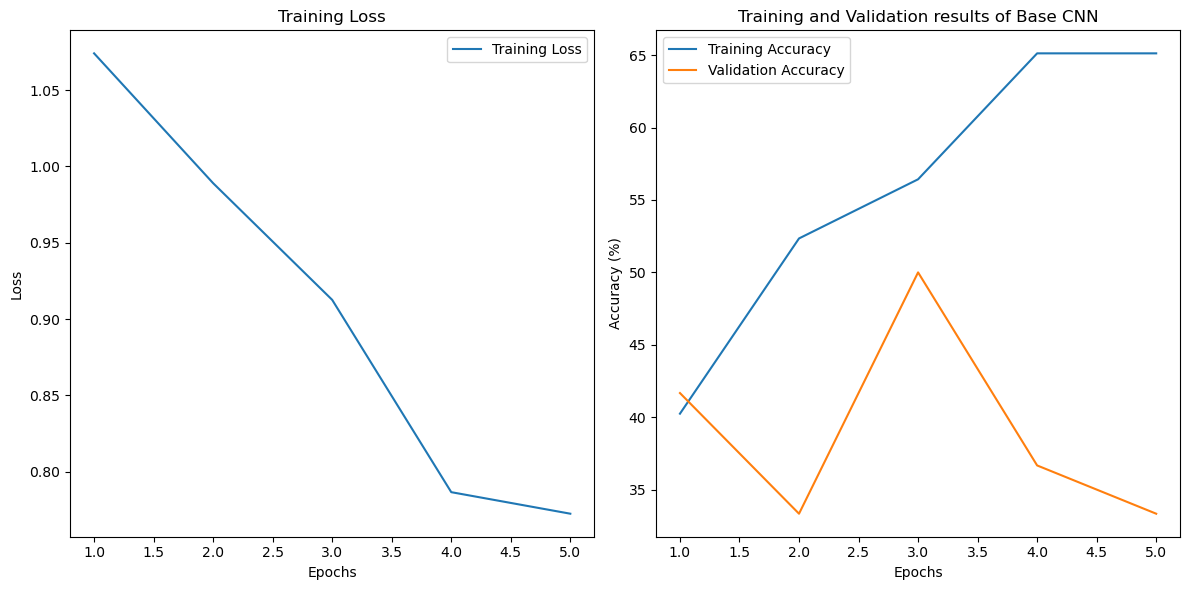

In [11]:
""" 
Visiualizing training and validation results of the Base model.
"""
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_count + 1), training_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_count + 1),
         training_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs_count + 1), validation_accuracies,
         label='Validation Accuracy')
plt.title('Training and Validation results of Base CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
""" 
Evaluating the base CNN model 
"""
base_model.eval()
testing_correct = 0
testing_total = 0
with torch.no_grad():
    for inputs, labels in testing_loader:
        outputs = base_model(inputs)
        _, predicted = outputs.max(1)
        testing_total += labels.size(0)
        testing_correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * testing_correct / testing_total
print(f'Test Accuracy for Base CNN: {100.*testing_correct/testing_total:.2f}%')

Test Accuracy for Base CNN: 36.00%


## Implement Improvement 1

- Larger input size (224x224) for better feature detection
- Data augmentation with random flips for better generalization
- ImageNet normalization for training stability

In [16]:
image_transform_improved = transforms.Compose([
    transforms.Resize((224, 224)),          # Increased from 32x32
    transforms.RandomHorizontalFlip(),      # New: data augmentation
    transforms.ToTensor(),      
    # using the mean and std of ImageNet images as they were calculated based on millions of images.            
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]) 
])


In [17]:
# Updated datasets with new transform
training_dataset_improved = datasets.ImageFolder(
    training_image_path, transform=image_transform_improved)
validation_dataset_improved = datasets.ImageFolder(
    validation_image_path, transform=image_transform_improved)
testing_dataset_improved = datasets.ImageFolder(
    testing_image_path, transform=image_transform_improved)

In [18]:
training_loader_improved = DataLoader(
    training_dataset_improved, batch_size=32, shuffle=True)
validation_loader_improved = DataLoader(
    validation_dataset_improved, batch_size=32)
testing_loader_improved = DataLoader(testing_dataset_improved, batch_size=32)

## Implement Improvement 2

- Three convolutional layers instead of one
- Added padding to maintain spatial dimensions
- Increased number of filters (32, 64, 128)


In [24]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # pooling and fully connected layers
        self.pooling = nn.MaxPool2d(2, 2)
        self.fully_connected_1 = nn.Linear(128 * 28 * 28, 512)
        self.fully_connected_2 = nn.Linear(512, num_classes)
        
        # dropout - overfitting fix
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))
        x = self.pooling(torch.relu(self.conv3(x)))
        
        
        x = x.view(-1, 128 * 28 * 28)
        
        
        x = torch.relu(self.fully_connected_1(x))
        x = self.dropout(x)
        x = self.fully_connected_2(x)
        
        return x


In [25]:
""" 
initializing the improved cnn modell 
"""
num_classes = len(training_dataset_improved.classes)
improved_model = ImprovedCNN(num_classes)

## Implement Improvement 3

- Using Adam optimizer instead of SGD
- Added dropout for regularization
- More epochs 


In [27]:
# Training components
improved_criterion = nn.CrossEntropyLoss()
improved_optimizer = torch.optim.Adam(
    improved_model.parameters(), lr=0.001)  # Changed to Adam

# Training loop
print("Starting training...")
epochs_count = 5 # reminder : change epoch to 15
best_val_acc = 0

for epoch in range(epochs_count):
    improved_model.train()
    training_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, labels in training_loader_improved:
        improved_optimizer.zero_grad()
        outputs = improved_model(inputs)
        loss = improved_criterion(outputs, labels)
        loss.backward()
        improved_optimizer.step()
        
        training_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        training_correct += (predicted == labels).sum().item()
        training_total += labels.size(0)

    # Calculate metrics
    epoch_loss = training_loss / len(training_loader_improved)
    epoch_accuracy = training_correct / training_total

    # Validation phase
    improved_model.eval()
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader_improved:
            outputs = improved_model(inputs)
            _, predicted = torch.max(outputs, 1)
            validation_correct += (predicted == labels).sum().item()
            validation_total += labels.size(0)

    validation_accuracy = validation_correct / validation_total

    # Save best model
    if validation_accuracy > best_val_acc:
        best_val_acc = validation_accuracy
        torch.save(improved_model.state_dict(), 'best_plant_disease_model.pth')

    print(f'Completed Improved CNN Epoch : {epoch+1}/{epochs_count} :')
    print(f'Training Loss: {epoch_loss/len(training_loader_improved):.3f}')
    print(f'Training Accuracy: {training_accuracy:.2f}%')
    print(f'Validation Accuracy: {validation_accuray:.2f}%\n')

Starting training...
Completed Improved CNN Epoch : 1/5 :
Training Loss: 0.005
Training Accuracy: 65.13%
Validation Accuracy: 33.33%

Completed Improved CNN Epoch : 2/5 :
Training Loss: 0.004
Training Accuracy: 65.13%
Validation Accuracy: 33.33%

Completed Improved CNN Epoch : 3/5 :
Training Loss: 0.003
Training Accuracy: 65.13%
Validation Accuracy: 33.33%

Completed Improved CNN Epoch : 4/5 :
Training Loss: 0.002
Training Accuracy: 65.13%
Validation Accuracy: 33.33%

Completed Improved CNN Epoch : 5/5 :
Training Loss: 0.003
Training Accuracy: 65.13%
Validation Accuracy: 33.33%



In [28]:
# Load the best model
improved_model.load_state_dict(torch.load('best_plant_disease_model.pth'))

# Evaluation function
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    improved_model.to(device)
    
    improved_model.eval()  # Set model to evaluation mode
    testing_correct = 0
    testing_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            testing_correct += (predicted == labels).sum().item()
            testing_total += labels.size(0)
    
    testing_accuracy = testing_correct / testing_total
    print(f"Test Accuracy: {testing_accuracy*100:.2f}%")


evaluate_model(improved_model, testing_loader_improved)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18424\2776900401.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  improved_model.load_state_dict(torch.load('best_plant_disease

Test Accuracy: 92.00%


## Hyper Parameter Optimization

Here we are planning to use GridSearch for the hyper parameter optimization.
For this we are planning to take Learning Rate, Batch Size and Number of Layers, Number of filters and Droupout rate hyper parameters for optimization.

In [29]:
class Params_improved_model(nn.Module):
    def __init__(self, number_of_layers, number_of_filters, dropout_probability):
        super(Params_improved_model, self).__init__()
        self.layers = nn.ModuleList()
        input_channels = 3

        # Convolutional layers
        for layer in range(number_of_layers):
            self.layers.append(
                nn.Conv2d(input_channels, number_of_filters * (2**layer), 3, padding=1))
            self.layers.append(nn.BatchNorm2d(number_of_filters * (2**layer)))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(2, 2))
            self.layers.append(nn.Dropout2d(dropout_probability))
            input_channels = number_of_filters * (2**layer)

        # feature size
        feature_size = 224 // (2**number_of_layers)
        final_channels = number_of_filters * (2**(number_of_layers-1))
        flat_features = final_channels * feature_size * feature_size

        self.classifier = nn.Sequential(
            nn.Linear(flat_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_probability),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        # Pass input through all layers
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [36]:
def train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5):
    best_val_acc = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

In [37]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'batch_size': [16, 32, 64],
    'n_layers': [2, 3, 4],
    'n_filters': [32, 64],
    'dropout_rate': [0.2, 0.3, 0.4]
}

In [38]:
import time

In [39]:
from itertools import product